In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

import xgboost as xgb

os.chdir(r'C:\Users\user\Desktop\test')

In [3]:
df = pd.read_csv('trainX.csv')
y = pd.read_csv('trainY.csv')
df.drop(columns='Id', inplace = True)
y.drop(columns='Id', inplace = True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.929616,0.316376,0.183919,0.328653,0.567725,0.595545,0.964515,0.878482,1.375367,0.653570,0.747715,0.961307,0.016072,0.106444,0.298704,0.656411,0.809813,0.872176,0.964648,0.723685
1,0.642475,0.717454,0.467599,0.523095,0.439645,0.729689,0.994015,0.910353,1.452346,0.170914,0.026849,0.800370,1.731525,0.024676,0.491747,0.526255,0.596366,0.051958,0.895090,0.728266
2,0.818350,0.500223,0.810189,0.154186,0.218950,0.258719,0.468106,0.617828,1.303015,0.178053,0.531450,0.167742,1.473041,0.928171,0.609494,0.150183,0.489627,0.377345,0.848601,0.911097
3,0.414510,0.340697,0.613797,0.325859,0.135894,0.742520,0.863478,0.832987,1.930107,0.684702,0.959388,0.534988,0.727508,0.771282,0.544182,0.243661,0.264543,0.856129,0.534726,0.988190
4,0.945372,0.533232,0.252493,1.158161,0.367439,0.498648,0.226575,0.475524,1.195289,0.312933,0.768735,0.781837,1.633210,0.949906,0.107323,0.910725,0.336055,0.826380,0.898101,0.042715


In [4]:
def errors(test, predict):
    print('R^2 score: {}'.format(r2_score(test, predict)))
    print('MAE: {}'.format(mean_absolute_error(test, predict)))

def fitting(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    res = model.predict(X_val)
    errors(y_val, res)

def random_search(model, X_train, y_train, X_val, y_val, params):
    model_rs = RandomizedSearchCV(model, params, cv = 4, n_iter = 60, verbose = 2, scoring = 'r2')
    model_rs.fit(X_train, y_train)
    print(model_rs.best_params_)
    model_rs_best = model_rs.best_estimator_
    errors(y_val, model_rs_best.predict(X_val))
    return model_rs_best

def param_search(model, X_train, y_train, X_val, y_val, target, params, param_list, xlim1, xlim2, train = True):
    r2_train = []
    r2_val = []
    for i in param_list:
        params[target] = i
        handle = model.set_params(**params)
        handle.fit(X_train, y_train)
        handle_res = handle.predict(X_val)
        if train:
            r2_train.append(r2_score(y_train, handle.predict(X_train)))
        r2_val.append(r2_score(y_val, handle_res))
        
    fig, ax = plt.subplots()
    fig.set_size_inches((16,4))
    if train:
        ax.plot(param_list, r2_train, color = 'red', label = 'r^2 on train')
    ax.plot(param_list, r2_val, color = 'black', label = 'r^2 on val')
    ax.grid(which = 'both')
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(param_list[1] - param_list[0]))
    ax.legend()
    plt.show()

In [5]:
X = df.copy()
X = (X*100).round(5)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,92.96161,31.63756,18.39188,32.86534,56.77250,59.55447,96.45145,87.84821,137.53671,65.35699,74.77148,96.13067,1.60719,10.64444,29.87037,65.64112,80.98126,87.21759,96.46476,72.36853
1,64.24753,71.74536,46.75990,52.30953,43.96446,72.96891,99.40146,91.03526,145.23456,17.09143,2.68493,80.03702,173.15249,2.46762,49.17473,52.62552,59.63660,5.19575,89.50895,72.82662
2,81.83500,50.02228,81.01894,15.41863,21.89500,25.87191,46.81058,61.78281,130.30148,17.80530,53.14499,16.77422,147.30411,92.81705,60.94937,15.01835,48.96267,37.73450,84.86014,91.10972
3,41.45101,34.06973,61.37967,32.58586,13.58936,74.25201,86.34783,83.29867,193.01071,68.47018,95.93877,53.49878,72.75082,77.12822,54.41823,24.36612,26.45427,85.61286,53.47261,98.81902
4,94.53718,53.32322,25.24926,115.81613,36.74388,49.86484,22.65750,47.55236,119.52894,31.29329,76.87354,78.18371,163.32096,94.99057,10.73229,91.07254,33.60552,82.63804,89.81006,4.27153


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
exp = X.copy()
exp = np.log(exp)
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(exp, y, test_size = 0.2, random_state = 42)

<h3>XGBoost Base</h3>

In [8]:
xgbr = xgb.XGBRegressor()
fitting(xgbr, X_exp_train, y_exp_train, X_exp_val, y_exp_val)

R^2 score: 0.5184133925834546
MAE: 3.9986372105009345


In [155]:
params = {'n_estimators': [200, 300, 400], 'learning_rate': [0.3, 0.5, 0.1, 0.05], \
         'max_depth': [5,6,7], 'gamma': [0, 0.03, 0.1], 'colsample_bytree': [0.5, 0.8, 1]}

random_search(xgbr, X_train, y_train, X_val, y_val, params)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1, total=   0.8s
[CV] n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1, total=   0.9s
[CV] n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1 
[CV]  n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1, total=   1.9s
[CV] n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1 
[CV]  n_estimators=200, max_depth=6, learning_rate=0.3, gamma=0.03, colsample_bytree=1, total=   1.2s
[CV] n_estimators=400, max_depth=6, learning_rate=0.3, gamma=0.1, colsample_bytree=0.8 
[CV]  n_estimators=400, max_depth=6, learning_rate=0.3, gamma=0.1, colsample_bytree=0.8, total=   1.9s
[CV] n_estimators=400, max_depth=6, learning_rate=0.3, gamma=0.1, colsample_bytree=0.8 
[CV]  n_estimators=400, max_depth=6, learning_rate=0.3, gamma=0.1, colsample_bytree=0.8, total=   1.5s
[CV] n_estimators=400, max_depth=6, learning_rate=0.3, gamma=0.1, colsample_bytree=0.8 
[CV]  n_estimators=400, max_depth=6, learning_rate

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.8min finished


{'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
R^2 score: 0.5893147003943509
MAE: 3.6485866804366753


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

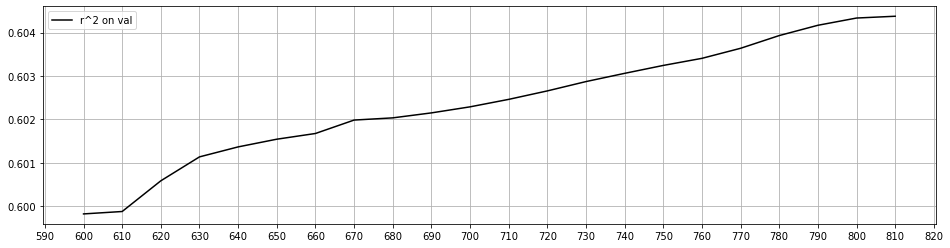

In [188]:
estimators = [i for i in range(600, 820, 10)]
target = 'n_estimators'
params = {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, estimators, 350, 510, train = False)

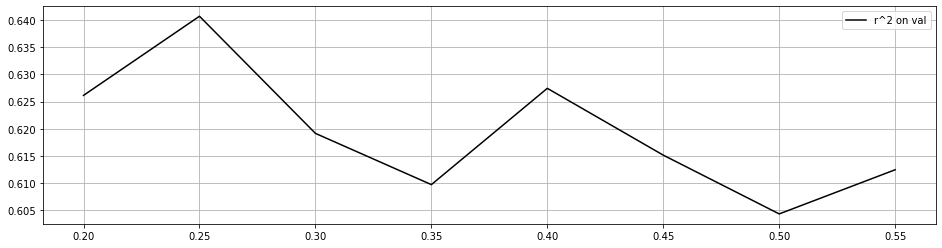

In [191]:
cols = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
target = 'colsample_bytree'
params = {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, cols, 0.2, 0.4, train = False)

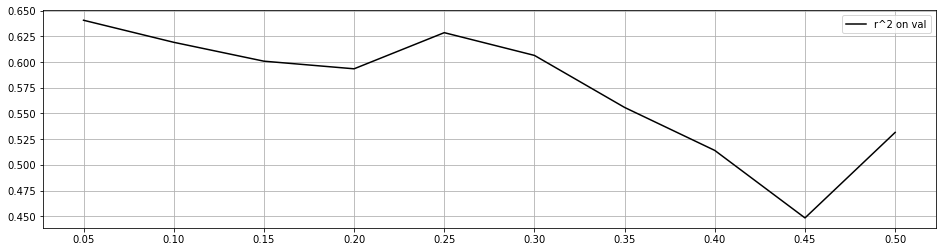

In [192]:
lear_rate = np.linspace(0.05, 0.5, 10)
target = 'learning_rate'
params = {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.25}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, lear_rate, 0.05, 0.5, train = False)

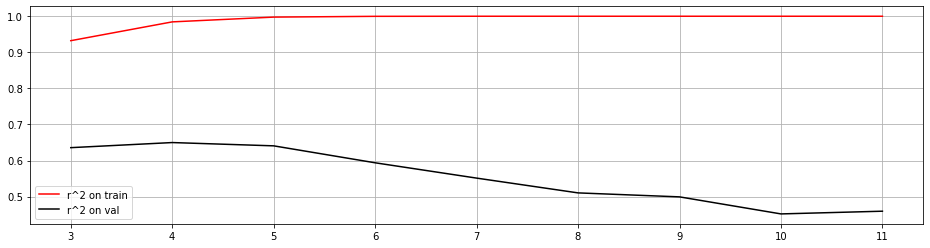

In [193]:
depth = [i for i in range(3,12)]
target = 'max_depth'
params = {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.25}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, depth, 3, 12, train = True)

In [ ]:
depth = [i for i in range(3,12)]
target = 'max_depth'
params = {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.25}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, depth, 3, 12, train = True)

In [194]:
xgb.XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)

<h3>Best XGBoost</h3>

In [22]:
params = {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.25}
xgb_best = xgb.XGBRegressor().set_params(**params)
fitting(xgb_best, X_train, y_train, X_val, y_val)

R^2 score: 0.6498051944499892
MAE: 3.3429258773768673


<h3>Light GBM</h3>

In [11]:
import lightgbm 
lgbm = lightgbm.LGBMRegressor()
fitting(lgbm, X_train, y_train, X_val, y_val)

R^2 score: 0.570716108870251
MAE: 3.7627026196714444


In [231]:
params = {'n_estimators': [400, 500, 600], 'learning_rate': [0.3, 0.5, 0.1, 0.05], \
         'max_depth': [3,4,5,6], 'num_leaves': [31, 40, 50], 'colsample_bytree': [0.3, 0.5, 0.6]}

lgbm = lightgbm.LGBMRegressor()
random_search(lgbm, X_train, y_train, X_val, y_val, params)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6, total=   0.4s
[CV] num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6, total=   0.4s
[CV] num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6 
[CV]  num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6, total=   0.4s
[CV] num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6 
[CV]  num_leaves=40, n_estimators=500, max_depth=4, learning_rate=0.3, colsample_bytree=0.6, total=   0.6s
[CV] num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6 
[CV]  num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6, total=   0.5s
[CV] num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6 
[CV]  num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6, total=   1.3s
[CV] num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.9min finished


{'num_leaves': 40, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.3}
R^2 score: 0.6305477673924489
MAE: 3.4980426254750228


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
              importance_type='split', learning_rate=0.05, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=40, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

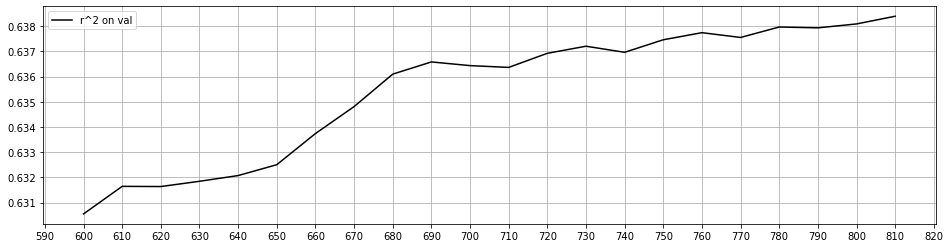

In [232]:
estimators = [i for i in range(600, 820, 10)]
target = 'n_estimators'
params = {'num_leaves': 40, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.3}

param_search(lightgbm.LGBMRegressor(), X_train, y_train, X_val, y_val, target, params, estimators, 600, 820, train = False)

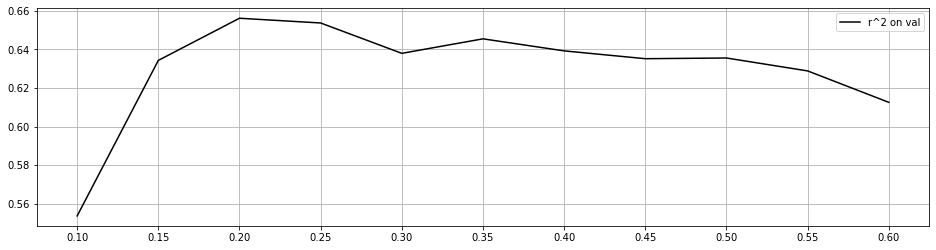

In [235]:
cols = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
target = 'colsample_bytree'
params = {'num_leaves': 40, 'n_estimators': 780, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.3}

param_search(lightgbm.LGBMRegressor(), X_train, y_train, X_val, y_val, target, params, cols, 0.2, 0.6, train = False)

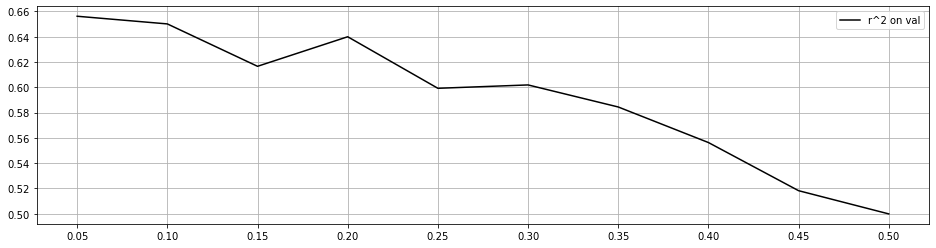

In [236]:
lear_rate = np.linspace(0.05, 0.5, 10)
target = 'learning_rate'
params = {'num_leaves': 40, 'n_estimators': 780, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.2}

param_search(lightgbm.LGBMRegressor(), X_train, y_train, X_val, y_val, target, params, lear_rate, 0.05, 0.5, train = False)

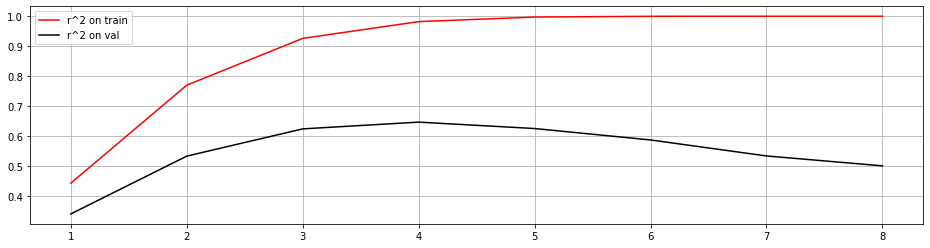

In [237]:
depth = [i for i in range(1,9)]
target = 'max_depth'
params = {'num_leaves': 40, 'n_estimators': 780, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.2}

param_search(xgb.XGBRegressor(), X_train, y_train, X_val, y_val, target, params, depth, 3, 12, train = True)

<h3>Best Light GBM</h3>

In [12]:
params = {'num_leaves': 40, 'n_estimators': 780, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.2}
lgbm = lightgbm.LGBMRegressor().set_params(**params)
fitting(lgbm, X_train, y_train, X_val, y_val)

R^2 score: 0.6561747193666504
MAE: 3.3340534728656497


<h3>Random Forest</h3>

In [239]:
rfr = RandomForestRegressor(n_estimators = 400)
fitting(rfr, X_train, y_train, X_val, y_val)

R^2 score: 0.407781055027728
MAE: 4.418719233502081


In [240]:
params = {'n_estimators': [400, 500, 600],'max_depth': [5,6,7], \
          'min_samples_leaf': [1, 2, 3], 'max_features': ['log2', 'sqrt']}
rfr = RandomForestRegressor()
random_search(rfr, X_train, y_train, X_val, y_val, params)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
[CV] n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5, total=   2.3s
[CV] n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5, total=   1.5s
[CV] n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5, total=   1.6s
[CV] n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_estimators=400, min_samples_leaf=1, max_features=log2, max_depth=5, total=   1.7s
[CV] n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5, total=   2.2s
[CV] n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5, total=   2.5s
[CV] n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5, total=   3.2s
[CV] n_estimators=500, min_samples_leaf=1, max_features=log2, max_depth=5 
[CV]  n_es

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  7.8min finished


{'n_estimators': 500, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7}
R^2 score: 0.3655596834403062
MAE: 4.5698335580741505


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
# params = {'n_estimators': 500, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1}
params = {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 12}

rfr = RandomForestRegressor().set_params(**params)
fitting(rfr, X_train, y_train, X_val, y_val)

R^2 score: 0.4238941438405379
MAE: 4.358417499253496


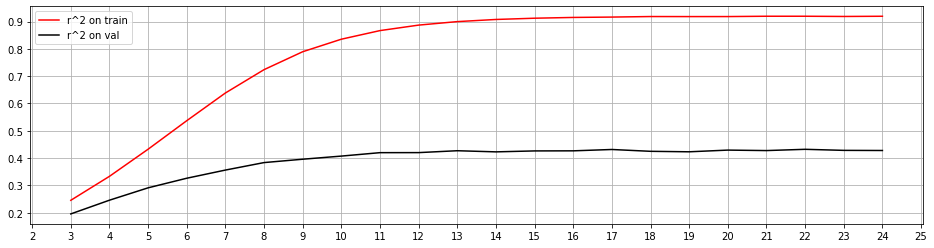

In [14]:
depth = [i for i in range(3,25)]
target = 'max_depth'
params = {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 12}

rfr = RandomForestRegressor()
param_search(rfr, X_train, y_train, X_val, y_val, target, params, depth, 3, 25, train = True)

<h3>Best Random Forest</h3>
<br> Плюс минус все одни и то же. Улучшить не получилось.

In [19]:
params = {'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': 12}

rfr_best = RandomForestRegressor()
fitting(rfr_best, X_train, y_train, X_val, y_val)

R^2 score: 0.41569197270321145
MAE: 4.416208805651411


Перенесём подобранный в другом файле GB.

In [25]:
gbr_handle = GradientBoostingRegressor(n_estimators = 420, max_depth = 5, \
                                   learning_rate = 0.1, max_features = 'log2', tol = 1e-7)
gbr_handle.fit(X_train, y_train)
gbr_handle_res = gbr_handle.predict(X_val)
errors(y_val, gbr_handle_res)

R^2 score: 0.6085997738622442
MAE: 3.575222030549065


<h3>Время стэкинга</h3>

In [29]:
level0 = list()
level0.append(('lgbm', lgbm))
level0.append(('bgr', gbr_handle))
level0.append(('rfr', rfr_best))
level0.append(('xgb', xgb_best))
level1 = LinearRegression()
model = StackingRegressor(estimators = level0, final_estimator = level1, cv = 5)
model.fit(X_train, y_train)
model_res = model.predict(X_val)
errors(y_val, model_res)

R^2 score: 0.695063971616706
MAE: 2.998701045414632


In [38]:
testX = pd.read_csv('testX.csv')
testX.drop(columns='Id', inplace = True)
testX = (testX*100).round(5)

In [39]:
testX

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,29.14592,91.12106,37.37661,44.07220,28.54551,41.32611,18.52666,14.76778,31.17549,99.83718,90.16154,86.47563,49.15122,21.19589,98.89273,22.36546,55.08099,12.74224,62.18105,11.31593
1,35.70061,57.90606,71.00145,14.72218,98.10632,14.51494,34.54019,71.01878,98.27227,59.75660,5.02413,80.87587,44.24001,18.76800,12.75010,78.30308,7.63322,73.29823,7.37983,46.77798
2,47.67763,39.21464,85.45005,49.72107,42.29844,2.67279,1.38629,9.78844,63.40575,81.22624,49.45396,91.75949,41.89073,54.23779,72.46246,52.43392,38.44601,55.93117,16.09486,12.00740
3,84.50727,47.38522,52.30790,72.75857,14.14436,86.21434,31.90082,8.66614,37.91243,60.59221,8.31183,6.44701,58.95396,47.30295,15.96873,49.47418,98.58357,97.73758,5.29248,49.23801
4,38.91153,94.76391,88.35608,73.00082,35.12033,44.90378,3.86267,61.95769,8.37699,75.61773,97.58008,18.35277,2.20213,24.17013,31.18134,51.69892,76.82921,43.86433,29.13547,65.36397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,44.01627,37.41791,8.33866,57.34574,75.02621,78.29651,56.33997,64.22679,69.00210,15.45541,54.06730,43.59859,91.24747,51.04086,30.45441,54.41097,80.15854,95.39775,28.23137,18.22715
1996,65.76814,72.12968,20.95813,80.40495,53.97363,54.12598,36.26337,45.86742,19.70536,44.68484,30.15670,93.90840,38.17697,72.90955,43.69165,65.80664,33.44960,38.31690,64.74738,86.34400
1997,59.36951,35.55190,4.52970,9.51915,88.71964,28.95047,47.33319,36.36324,78.26405,1.04146,55.97110,13.17921,36.69804,86.47318,54.79559,83.19364,27.43162,28.02235,80.46837,35.87512
1998,70.61913,71.35010,36.04775,32.79576,78.43850,17.92795,66.26973,92.40389,36.48553,66.26241,53.03006,40.77662,16.00515,58.39514,28.45528,21.66553,61.58872,12.26233,97.63482,96.52533


In [40]:
to_submit = model.predict(testX)
Ypd = pd.DataFrame({'Value' : to_submit})
Ypd['Id'] = range(len(Ypd))
Ypd.to_csv('my_solution.csv', index=False)